In [1]:
import tensorflow as tf

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import TextVectorization,Input,Dense,Embedding,GlobalMaxPooling1D,Conv1D,MaxPooling1D
from tensorflow.keras.models import Model

In [14]:
# Unfortunately this URL doesn't work directly with pd.read_csv
!wget -nc https://lazyprogrammer.me/course_files/spam.csv

File ‘spam.csv’ already there; not retrieving.



In [15]:
df = pd.read_csv('spam.csv',encoding='ISO-8859-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [16]:
!head spam.csv

v1,v2,,,
ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...",,,
ham,Ok lar... Joking wif u oni...,,,
spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's,,,
ham,U dun say so early hor... U c already then say...,,,
ham,"Nah I don't think he goes to usf, he lives around here though",,,
spam,"FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, �1.50 to rcv",,,
ham,Even my brother is not like to speak with me. They treat me like aids patent.,,,
ham,As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune,,,
spam,WINNER!! As a valued network customer you have been selected to receivea �900 prize reward! To claim call 09061701461. Claim 

In [17]:
df = df.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4'],axis=1)
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [18]:
df.columns = ['labels','data']
df.head()

,labels,data
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [19]:
df['b_labels'] = df['labels'].map({'ham':0,'spam':1})
df.head()

,labels,data,b_labels
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


In [20]:
Y = df['b_labels'].values
Y

array([0, 0, 1, ..., 0, 0, 0])

In [21]:
df_train,df_test,Y_train,Y_test = train_test_split(
    df['data'],Y,test_size=0.33)

In [22]:
# create tf datasets
train_ds = tf.data.Dataset.from_tensor_slices((df_train.values,Y_train))
test_ds = tf.data.Dataset.from_tensor_slices((df_test.values,Y_test))

In [23]:
# Convert sentences to sequences
MAX_VOCAB_SIZE = 20_000
vectorization = TextVectorization(max_tokens=MAX_VOCAB_SIZE)
vectorization.adapt(train_ds.map(lambda x,y:x))

In [25]:
vectorization.get_vocabulary()

['',
 '[UNK]',
 'i',
 'to',
 'you',
 'a',
 'the',
 'u',
 'and',
 'is',
 'in',
 'my',
 'me',
 'for',
 'your',
 'it',
 'of',
 'have',
 'call',
 'on',
 'that',
 'are',
 'now',
 '2',
 'but',
 'not',
 'im',
 'so',
 'can',
 'at',
 'be',
 'or',
 'will',
 'do',
 'just',
 'ur',
 'get',
 'if',
 'with',
 'no',
 'we',
 'this',
 'ltgt',
 'its',
 'up',
 'from',
 '4',
 'all',
 'what',
 'ok',
 'when',
 'free',
 'dont',
 'out',
 'how',
 'go',
 'like',
 'know',
 'got',
 'good',
 'come',
 'then',
 'was',
 'ill',
 'am',
 'time',
 'only',
 'love',
 'day',
 'there',
 'as',
 'send',
 'want',
 'by',
 'about',
 'text',
 'need',
 'one',
 'he',
 'txt',
 'going',
 'lor',
 'our',
 'sorry',
 'see',
 'tell',
 'well',
 'today',
 'still',
 'back',
 'new',
 'home',
 'stop',
 'r',
 'mobile',
 'later',
 'take',
 'been',
 'her',
 'da',
 'think',
 'please',
 'hey',
 'she',
 'phone',
 'n',
 'hi',
 'much',
 'week',
 'they',
 'happy',
 'him',
 'has',
 'oh',
 'here',
 'did',
 'cant',
 'reply',
 'great',
 'dear',
 'too',
 'more

In [26]:
# Shuffle and batch the dataset
train_ds = train_ds.shuffle(10000).batch(32).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.batch(32).prefetch(tf.data.AUTOTUNE)

In [27]:
V = len(vectorization.get_vocabulary())
V

7622

In [28]:
input_sequences_train = vectorization(df_train.values)
input_sequences_test = vectorization(df_test.values)

In [29]:
input_sequences_train.shape

TensorShape([3733, 171])

In [30]:
input_sequences_test.shape

TensorShape([1839, 115])

In [31]:
T = input_sequences_train.shape[1]
T

171

In [32]:
vectorization2 = TextVectorization(
    max_tokens=MAX_VOCAB_SIZE,
    output_sequence_length=T,
    vocabulary = vectorization.get_vocabulary(),
)


In [33]:
# Create the model

D = 20

i = Input(shape=(1,),dtype=tf.string)
x = vectorization2(i)
x = Embedding(V,D)(x)
x = Conv1D(32,3,activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(64,3,activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(128,3,activation='relu')(x)
X = GlobalMaxPooling1D()(x)
x = Dense(1,activation='sigmoid')(x)

model = Model(i,x)

In [35]:
# Create the model

D = 20

i = Input(shape=(1,),dtype=tf.string)
x = vectorization2(i)
x = Embedding(V,D)(x)
x = Conv1D(32,3,activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(64,3,activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(128,3,activation='relu')(x)
# x = GlobalMaxPooling1D()(x) # Remove this line or adjust architecture to produce correct output shape
x = GlobalMaxPooling1D()(x) # This is added to collapse the temporal dimension
x = Dense(1,activation='sigmoid')(x)

model = Model(i,x)

In [36]:
#Compile and fit
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

r = model.fit(
    train_ds,
    epochs=5,
    validation_data=test_ds
)

Epoch 1/5
117/117 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.8353 - loss: 0.4595 - val_accuracy: 0.9364 - val_loss: 0.1950
Epoch 2/5
117/117 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.9570 - loss: 0.1313 - val_accuracy: 0.9750 - val_loss: 0.0835
Epoch 3/5
117/117 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.9879 - loss: 0.0331 - val_accuracy: 0.9782 - val_loss: 0.0753
Epoch 4/5
117/117 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.9981 - loss: 0.0085 - val_accuracy: 0.9799 - val_loss: 0.0785
Epoch 5/5
117/117 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.9995 - loss: 0.0038 - val_accuracy: 0.9777 - val_loss: 0.0863


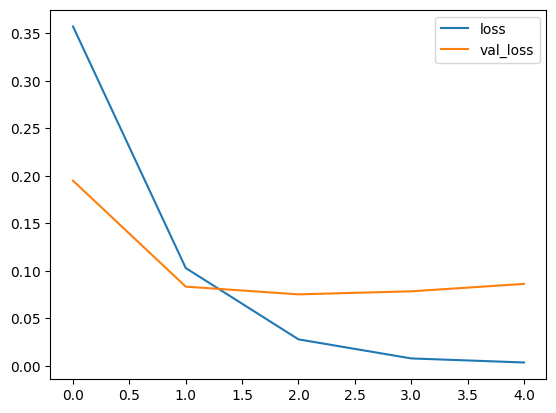

In [37]:
plt.plot(r.history['loss'],label='loss')
plt.plot(r.history['val_loss'],label='val_loss')
plt.legend()

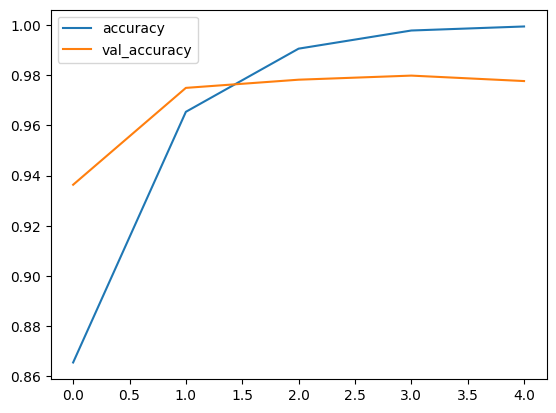

In [38]:
plt.plot(r.history['accuracy'],label='accuracy')
plt.plot(r.history['val_accuracy'],label='val_accuracy')
plt.legend()

<Axes: >

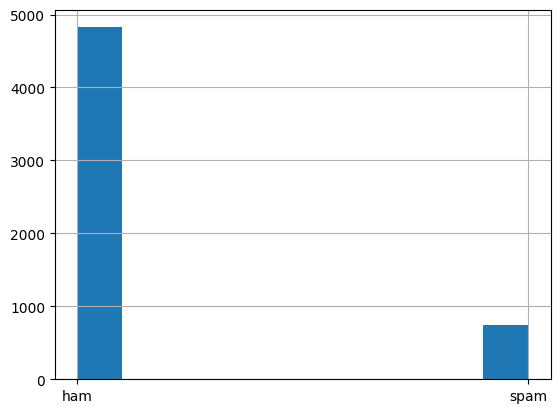

In [39]:
df['labels'].hist()

In [40]:
from sklearn.metrics import f1_score
f1_score(Y_train,model.predict(df_train.values) > 0.5)

117/117 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step


0.9969909729187563

In [42]:
f1_score(Y_test,model.predict(df_test.values) > 0.5)

58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


0.9118279569892473

In [48]:
input_sequences_train = vectorization2(df_train.values)
input_sequences_test = vectorization2(df_test.values)

In [49]:
#creates tf datasets
train_ds = tf.data.Dataset.from_tensor_slices((input_sequences_train,Y_train))
test_ds = tf.data.Dataset.from_tensor_slices((input_sequences_test,Y_test))

In [50]:
# Shuffle and batch the dataset
train_ds = train_ds.shuffle(10000).batch(32).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.batch(32).prefetch(tf.data.AUTOTUNE)

In [51]:
i = Input(shape=(T,))
x = Embedding(V,D)(i)
x = Conv1D(32,3,activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(64,3,activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(128,3,activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(1,activation='sigmoid')(x)

model = Model(i,x)

In [52]:
#Compile and fit
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

r = model.fit(
    train_ds,
    epochs=5,
    validation_data=test_ds
)

Epoch 1/5
117/117 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.8432 - loss: 0.4501 - val_accuracy: 0.8657 - val_loss: 0.2286
Epoch 2/5
117/117 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.9422 - loss: 0.1611 - val_accuracy: 0.9712 - val_loss: 0.0953
Epoch 3/5
117/117 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.9875 - loss: 0.0515 - val_accuracy: 0.9685 - val_loss: 0.1032
Epoch 4/5
117/117 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.9925 - loss: 0.0187 - val_accuracy: 0.9750 - val_loss: 0.0947
Epoch 5/5
117/117 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.9979 - loss: 0.0072 - val_accuracy: 0.9739 - val_loss: 0.1056


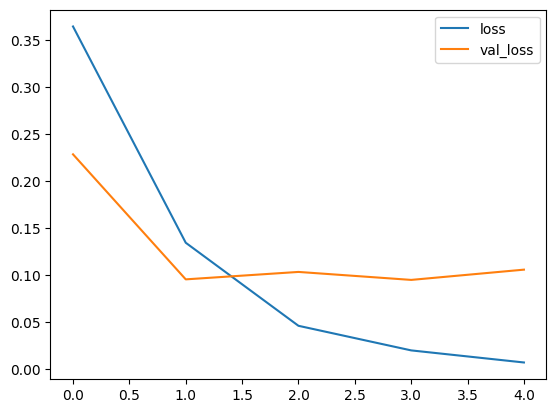

In [53]:
plt.plot(r.history['loss'],label='loss')
plt.plot(r.history['val_loss'],label='val_loss')
plt.legend()

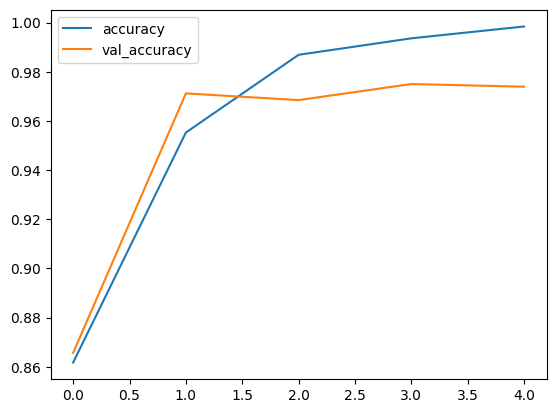

In [54]:
plt.plot(r.history['accuracy'],label='accuracy')
plt.plot(r.history['val_accuracy'],label='val_accuracy')
plt.legend()